### Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

### Globals

In [9]:
data_filepath = '../original_data/'
density_reports_filepath = data_filepath + 'DensityReports.xlsx'
historical_incidents_filepath = data_filepath + 'HistoricalIncidents.xlsx'
product_attributes_filepath = data_filepath + 'ProductAttributes.xlsx'
supplier_scorecard_filepath = data_filepath + 'SupplierScorecard.xlsx'

### Load Data

In [55]:
density_reports = pd.read_excel(density_reports_filepath)
product_attributes = pd.read_excel(product_attributes_filepath)
supplier_scorecard = pd.read_excel(supplier_scorecard_filepath)


## Data Preparation

### Basic Transformations

In [56]:
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

density_reports['PackagingQuality'] = density_reports['PackagingQuality'].str.upper()
unique_packaging_quality = density_reports['PackagingQuality'].unique()
print(unique_packaging_quality)

['Good' 'Bad' 'GOOD' 'Uncertain' 'bad']
['GOOD' 'BAD' 'UNCERTAIN']


In [57]:
unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

# Define the mappings
supplier_mappings = {
    'SupplierA': 'A',
    'supplierA': 'A',
    'SuplA': 'A',
    'SupplierB': 'B',
    'SuppB': 'B',
    'SupplierC': 'C',
    'SupllierC': 'C',
    'SupplierD': 'D',
    'SupplierE': 'E',
    'SupplierF': 'F',
    'SPLF': 'F',
    'SupplierG': 'G',
    'supplierh': 'H',
    'SupplierH': 'H'
}
# Apply the mapping to standardize SupplierName
density_reports['SupplierName'] = density_reports['SupplierName'].map(supplier_mappings).fillna(density_reports['SupplierName'])

unique_supplier = density_reports['SupplierName'].unique()
print(unique_supplier)

['SupplierA' 'SupplierC' 'SupplierD' 'SupplierB' 'supplierA' 'SupplierF'
 'SupplierE' 'supplierh' 'SupplierH' 'SuppB' 'SupplierG' 'SupllierC'
 'SPLF' 'SuplA']
['A' 'C' 'D' 'B' 'F' 'E' 'H' 'G']


In [58]:
unique_fold_method = density_reports['ProposedFoldingMethod'].unique()
print(unique_fold_method)

# Define the mappings
fold_method_mappings = {
    'Method1': 'Method1',
    'Methd1': 'Method1',
    'Method2': 'Method2',
    'Method_2': 'Method2',
    'Method3': 'Method3',
    'FoldX': 'MethodX'
}
# Apply the mapping to standardize SupplierName
density_reports['ProposedFoldingMethod'] = density_reports['ProposedFoldingMethod'].map(fold_method_mappings).fillna(density_reports['ProposedFoldingMethod'])

# Drop rows with NaN values in 'ProposedFoldingMethod'
density_reports = density_reports.dropna(subset=['ProposedFoldingMethod'])

unique_fold_method = density_reports['ProposedFoldingMethod'].unique()
print(unique_fold_method)

['Method2' 'Method1' 'Method3' 'Method_2' nan 'Methd1' 'FoldX']
['Method2' 'Method1' 'Method3' 'MethodX']


In [59]:
unique_layout = density_reports['ProposedLayout'].unique()
print(unique_layout)

# Define the mappings
layout_mappings = {
    'LayoutA': 'LayoutA',
    'layouta': 'LayoutA',
    'LayoutB': 'LayoutB',
    'LayoutC': 'LayoutC',
    'LayC': 'LayoutC',
    'LayoutD': 'LayoutD',
    'LayoutE': 'LayoutE',
    'LayoutX': 'LayoutX',
    'Box9': 'LayoutX',
}
# Apply the mapping to standardize SupplierName
density_reports['ProposedLayout'] = density_reports['ProposedLayout'].map(layout_mappings).fillna(density_reports['ProposedLayout'])

# Drop rows with NaN values in 'ProposedLayout'
density_reports = density_reports.dropna(subset=['ProposedLayout'])

unique_layout = density_reports['ProposedLayout'].unique()
print(unique_layout)

['LayoutC' 'LayoutB' 'LayoutA' 'LayoutD' 'LayoutE' 'LayoutX' 'Box9'
 'layouta' 'LayC']
['LayoutC' 'LayoutB' 'LayoutA' 'LayoutD' 'LayoutE' 'LayoutX']


In [60]:
unique_garment_type = density_reports['GarmentType'].unique()
print(unique_garment_type)

['Pants' 'T-Shirt' 'Shirt' 'Coat' 'Dress' 'Blouse' 'Suit' 'Hoodie' 'Skirt'
 'Jacket' 'Shorts' 'Sweater']


In [61]:
unique_material = density_reports['Material'].unique()
print(unique_material)

['Polyester' 'Denim' 'Cotton' 'Linen' 'Wool' 'Silk']


### Join Density Reports and Product Attributes Data

In [62]:
report_product_attributes = pd.merge(
    density_reports[["ProductReference", "SupplierName", "GarmentType", "Material", 
                     "Weight", "ProposedUnitsPerCarton", "ProposedFoldingMethod", 
                     "ProposedLayout", "PackagingQuality"
                     ]], 
    product_attributes[['ProductReference', 'Size', 'Collection']], 
    on="ProductReference", 
    how='inner'
    )

In [63]:
report_product_attributes.head()

,ProductReference,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,PackagingQuality,Size,Collection
0,PRD07271,A,Pants,Polyester,0.35,29.0,Method2,LayoutC,GOOD,S,Winter
1,PRD00861,C,T-Shirt,Denim,0.21,20.0,Method2,LayoutB,GOOD,M,Winter
2,PRD05391,A,Shirt,Cotton,0.20,31.0,Method1,LayoutA,GOOD,S,Winter
3,PRD05192,A,Coat,Cotton,1.30,5.0,Method1,LayoutD,GOOD,XL,Winter
4,PRD05735,A,Coat,Polyester,1.11,9.0,Method2,LayoutD,GOOD,M,Autumn


In [64]:
report_product_attributes.dtypes

ProductReference           object
SupplierName               object
GarmentType                object
Material                   object
Weight                    float64
ProposedUnitsPerCarton    float64
ProposedFoldingMethod      object
ProposedLayout             object
PackagingQuality           object
Size                       object
Collection                 object
dtype: object

## Association Analysis - Product Attributes

In [65]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))


In [66]:
categorical_columns = ['SupplierName', 'GarmentType', 'Material', 'ProposedFoldingMethod', 
                       'ProposedLayout', 'Size', 
                       'Collection']
results = []

for i, col1 in enumerate(categorical_columns):
    for col2 in categorical_columns[i+1:]:
        v = cramers_v(report_product_attributes[col1], report_product_attributes[col2])
        results.append({'Var1': col1, 'Var2': col2, "CramersV": v})

cramers_v_df = pd.DataFrame(results).sort_values(by='CramersV', ascending=False)
cramers_v_df

,Var1,Var2,CramersV
11,Material,ProposedFoldingMethod,0.564221
8,GarmentType,ProposedLayout,0.461266
12,Material,ProposedLayout,0.085167
9,GarmentType,Size,0.028900
14,Material,Collection,0.028399
6,GarmentType,Material,0.028119
10,GarmentType,Collection,0.027595
15,ProposedFoldingMethod,ProposedLayout,0.024207
13,Material,Size,0.022407
20,Size,Collection,0.021282


## Correlation Analysis - Supplier Metrics

In [67]:
supplier_scorecard.isnull().sum()

SupplierName                  0
Month                         0
PackagesHandled               0
BadPackagingRate (%)          0
TotalIncidents                0
AverageCostPerIncident (€)    0
OnTimeDeliveryRate (%)        0
AnomaliesDetected             0
dtype: int64

In [68]:
supplier_scorecard.dtypes

SupplierName                   object
Month                          object
PackagesHandled                 int64
BadPackagingRate (%)          float64
TotalIncidents                  int64
AverageCostPerIncident (€)    float64
OnTimeDeliveryRate (%)        float64
AnomaliesDetected               int64
dtype: object

In [69]:
# define correlation matrix for numerical columns
numerical_columns = supplier_scorecard.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = supplier_scorecard[numerical_columns].corr()

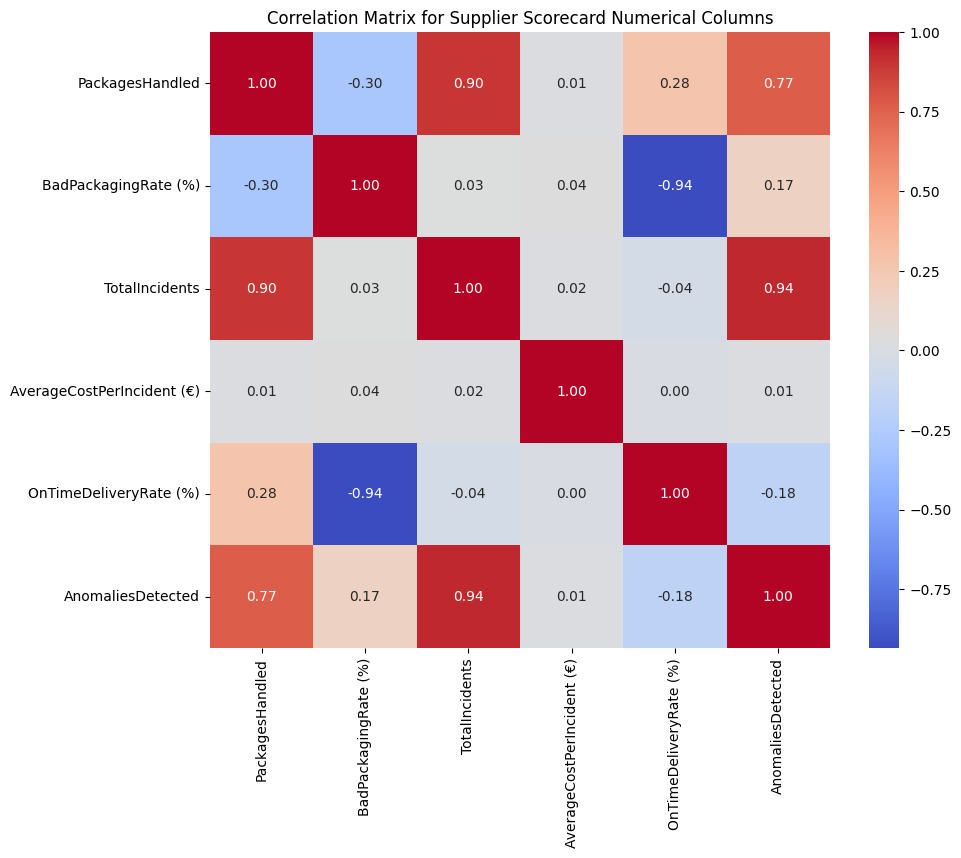

In [70]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Supplier Scorecard Numerical Columns')
plt.show()

## Mutual Information Analysis

In [71]:
df = report_product_attributes.copy()

# Separate features and target, remove unnecessary columns
X = df.drop(columns=['PackagingQuality', 'ProductReference'])
y = df['PackagingQuality']

In [72]:
# Label encode all categorical variables (both features and target)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_encoded = X.copy()
discrete_features = []

for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col])
        discrete_features.append(True)
    else:
        discrete_features.append(False)  # float columns

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features=discrete_features)

# Present results
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MutualInformation': mi_scores
}).sort_values(by='MutualInformation', ascending=False)

print(mi_df)

                  Feature  MutualInformation
0            SupplierName           0.032370
2                Material           0.004636
5   ProposedFoldingMethod           0.003300
3                  Weight           0.002114
4  ProposedUnitsPerCarton           0.001938
1             GarmentType           0.001059
6          ProposedLayout           0.001041
7                    Size           0.000010
8              Collection           0.000004


## Outlier Analysis

### Numerical Features

In [73]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.covariance import EmpiricalCovariance
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [74]:
def get_outlier_percentage(X, feature):
    iso = IsolationForest(contamination=0.01, random_state=42)
    # IsolationForest expects 2D input
    preds = iso.fit_predict(X[[feature]])
    # Outliers are labeled as -1
    outlier_count = (preds == -1).sum()
    percentage = 100 * outlier_count / len(X)
    return percentage

weight_outlier_pct = get_outlier_percentage(X, 'Weight')
units_outlier_pct = get_outlier_percentage(X, 'ProposedUnitsPerCarton')

print(f"Weight outlier percentage: {weight_outlier_pct:.2f}%")
print(f"ProposedUnitsPerCarton outlier percentage: {units_outlier_pct:.2f}%")

Weight outlier percentage: 0.98%
ProposedUnitsPerCarton outlier percentage: 0.76%


In [75]:
def visualize_boxplots(df: pd.DataFrame, col: object):
    """
    Display boxplots for the specified numeric columns.
    """
    df[[col]].boxplot()
    plt.title(f"Boxplot of {col} Feature")
    plt.xlabel("Feature")
    plt.ylabel("Value")
    plt.show()

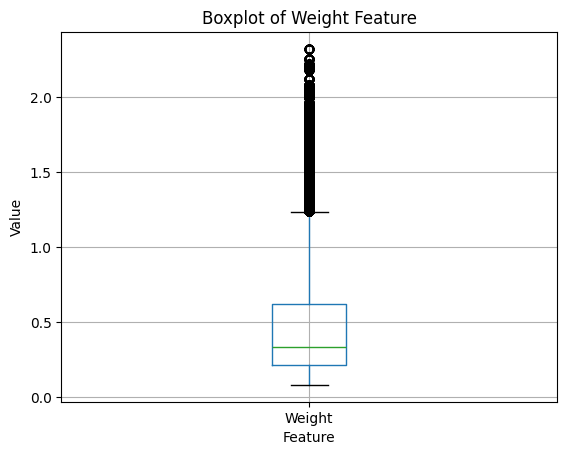

In [76]:
visualize_boxplots(X, 'Weight')

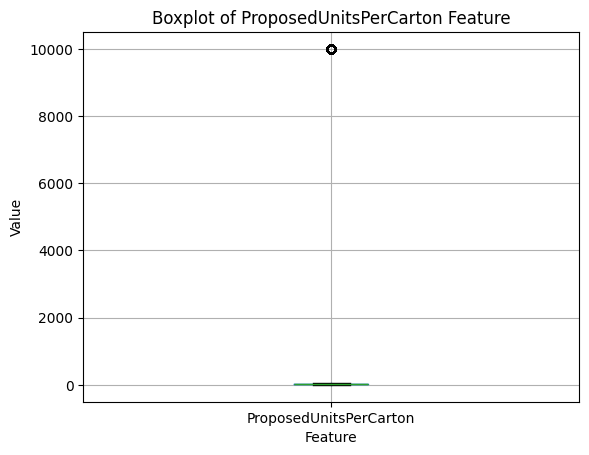

In [77]:
visualize_boxplots(X, 'ProposedUnitsPerCarton')

### Categorical Features

In [78]:
def detect_rare_categories(df: pd.DataFrame, col: str, freq_threshold: float = 0.05) -> pd.Index:
    """
    Return the row indices where the value in `col` is one of the 'rare' categories
    whose normalized frequency < freq_threshold.
    """
    freq = df[col].value_counts(normalize=True)
    rare_vals = freq[freq < freq_threshold].index
    return df[df[col].isin(rare_vals)].index

In [79]:
cat_cols = ['SupplierName', 'GarmentType', 'Material', 'ProposedFoldingMethod', 'ProposedLayout', 'Size', 'Collection']
rare_outliers = {col: detect_rare_categories(df, col, 0.05).tolist()
                 for col in cat_cols}
print(rare_outliers)

{'SupplierName': [27, 28, 57, 72, 107, 200, 201, 223, 283, 290, 299, 314, 321, 348, 362, 365, 414, 427, 489, 560, 566, 574, 606, 610, 648, 653, 658, 720, 723, 738, 772, 775, 816, 887, 895, 896, 913, 923, 972, 1021, 1032, 1033, 1058, 1059, 1071, 1086, 1094, 1114, 1172, 1178, 1190, 1243, 1381, 1398, 1466, 1502, 1505, 1543, 1644, 1692, 1696, 1710, 1721, 1765, 1769, 1795, 1796, 1808, 1913, 1943, 1962, 2046, 2051, 2055, 2075, 2137, 2158, 2159, 2181, 2286, 2313, 2335, 2337, 2356, 2383, 2486, 2538, 2554, 2565, 2583, 2588, 2599, 2637, 2652, 2677, 2687, 2745, 2752, 2773, 2799, 2859, 2922, 2987, 3015, 3019, 3049, 3074, 3108, 3126, 3134, 3291, 3292, 3301, 3360, 3496, 3506, 3525, 3536, 3552, 3594, 3595, 3615, 3619, 3631, 3650, 3760, 3783, 3810, 3830, 3892, 3913, 3970, 4000, 4034, 4124, 4127, 4139, 4207, 4251, 4268, 4297, 4299, 4398, 4403, 4429, 4440, 4462, 4465, 4515, 4528, 4537, 4582, 4624, 4663, 4721, 4740, 4750, 4791, 4816, 4861, 4931, 4967, 5151, 5204, 5231, 5241, 5264, 5280, 5313, 5362, 5377,

In [80]:
df.iloc[rare_outliers['SupplierName']]["SupplierName"].value_counts()

SupplierName
H    14886
Name: count, dtype: int64

In [88]:
percentage_h = 100 * (X['SupplierName'] == 'H').sum() / len(X)
print(f"Percentage of records with SupplierName = 'H': {percentage_h:.4f}%")

Percentage of records with SupplierName = 'H': 3.0872%


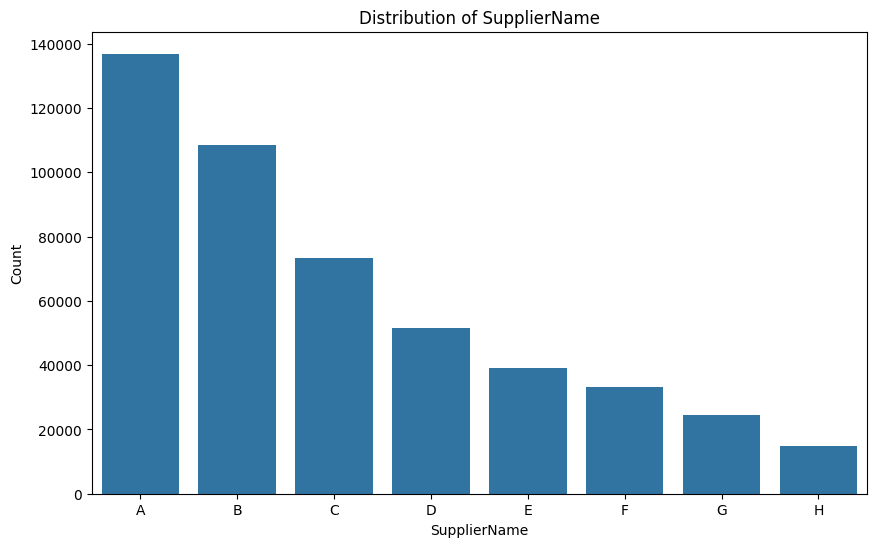

In [87]:
plt.figure(figsize=(10, 6))
sns.countplot(data=X, x='SupplierName', order=X['SupplierName'].value_counts().index)
plt.title('Distribution of SupplierName')
plt.xlabel('SupplierName')
plt.ylabel('Count')
plt.show()